<div style="background-color:#5F9EA0; 
            color:white; 
            padding:15px; 
            border-radius:10px; 
            text-align:center; 
            font-size:30px; 
            font-weight:bold;">
    Detecting Deep Fakes - A Deep Learning Computer Vision Task<br>
    <span style="font-size:20px; font-weight:normal;">
        Hairy Feet: Anna, Jacob, Johannes
    </span>
</div>

<h1 id = setup style = 'font-size:30px; background: linear-gradient(90deg, #5F9EA0, #7AC5CD, #8EE5EE); color: white; padding: 10px;  border-radius: 10px;'>
    1. Introduction: Project Overview & Data 
</h1

<div style="background-color:#D2EFF1;
            color:#333333;
            padding:12px 16px;
            border-radius:10px;
            margin:10px 0;">
   </b>
    
In this project, we build a deep learning computer vision model to distinguish between real human faces, and AI-generated (deepfake) face images. 

We use the **DeepDetect-2025** dataset from Kaggle, which contains over 100k labeled images of faces, split into two classes: real and fake. The goal is to train a binary classifier that can automatically detect whether an image is genuine or AI generated.

# 2. Methods

## 2.1 Importing and Preparing Data

<div style="background-color:#D2EFF1;
            color:#333333;
            padding:12px 16px;
            border-radius:10px;
            margin:10px 0;">
   </b>

The DeepDetect-2025 dataset is organized into separate "train" and "test" folders, each containing two subfolders:

- "real" = real human face images  
- "fake" = AI-generated (deepfake) face images  

We will:
- Set a fixed image size and batch size
- Point TensorFlow to the "train" and "test" directories


In [5]:
import tensorflow as tf

cifake_train_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train"
cifake_test_dir  = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test"

df20k_dir = "/kaggle/input/deepfake-vs-real-20k/Deep-vs-Real"

hf_dir = "/kaggle/input/human-faces-dataset/Human Faces Dataset"

ds200k_dir = "/kaggle/input/200k-real-vs-ai-visuals-by-mbilal/my_real_vs_ai_dataset/my_real_vs_ai_dataset"



<div style="background-color:#D2EFF1;
            color:#333333;
            padding:12px 16px;
            border-radius:10px;
            margin:10px 0;">
   </b>
    
Now we create the training, validation and test sets. 
We use tf.keras.utils.image_dataset_from_directory to:

- Load images from the "train"  directory
- Automatically split the training data into:
  - **80% training**
  - **20% validation**

The images in the "test" directory are used as a separate held-out test set that we will only use for final evaluation.

In [7]:
# Helper function for getting dataset
def create_ds(directory, subset, labels, IMG_SIZE=(224,224), BATCH_SIZE=None, shuffle=True):
    ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        validation_split=0.2 if subset else None, # Only split if subset is asked for
        subset=subset,
        seed=2025,
        class_names=labels,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='int',
        shuffle=shuffle 
    )
    return ds

# --- CIFAKE ---
ds_train_cifake = create_ds(cifake_train_dir, 'training', ['FAKE', 'REAL'])
ds_val_cifake   = create_ds(cifake_train_dir, 'validation', ['FAKE', 'REAL'])

ds_train_cifake = ds_train_cifake.apply(tf.data.experimental.ignore_errors()) # Because it has corrupted files that crash the system otherwise

#-- 200K Dataset--
ds_train_200k = create_ds(ds200k_dir, 'training', ['ai_images', 'real'])
ds_val_200k   = create_ds(ds200k_dir, 'validation', ['ai_images', 'real'])

# CIFAKE hold-out set
ds_test_cifake = create_ds(cifake_test_dir, None, ['FAKE', 'REAL'], shuffle = False)

# Out-of-Distribution (face) sets

# --- Deepfake 20k ---
ds_ood_df20k = create_ds(df20k_dir, None, ['Deepfake', 'Real'], shuffle = False)

# --- HF Dataset ---
ds_ood_hf = create_ds(hf_dir, None , ['AI-Generated Images', 'Real Images'], shuffle = False)

# 2. Concatenate them (Append HF to the end of DF20k)
ds_ood_combined = ds_ood_df20k.concatenate(ds_ood_hf)

print("Datasets created!")

Found 20000 files belonging to 2 classes.
Found 19219 files belonging to 2 classes.
Found 9630 files belonging to 2 classes.
Datasets created!


In [8]:
# Batch size
BATCH_SIZE = 64

# Define a helper to enforce shapes
def force_shape(image, label):
    # Explicitly set the shape. This converts RaggedTensors to Dense Tensors.
    image = tf.ensure_shape(image, (224, 224, 3))
    label = tf.ensure_shape(label, ())
    return image, label

# Full dataset function
def ds_full(datasets, weights, batch_size = 64):
    AUTOTUNE = tf.data.AUTOTUNE
    
    ds_full = tf.data.Dataset.sample_from_datasets(
        datasets,
        weights=weights, # Optional: Balance the datasets if one is huge
        stop_on_empty_dataset=False
    )
 
    #ds_full = ds_full.unbatch() # Safety check to stop code from crashing if cell is run twice
    
    ds_full = ds_full.map(force_shape, num_parallel_calls=tf.data.AUTOTUNE)

    ds_full = ds_full.shuffle(buffer_size=1000)
    ds_full = ds_full.batch(batch_size)
    ds_full = ds_full.prefetch(tf.data.AUTOTUNE)

    return ds_full

# Test set function
def prepare_test_set(ds, batch_size=64):
    AUTOTUNE = tf.data.AUTOTUNE

    #ds = ds.unbatch() # Safety check to stop code from crashing if cell is run twice
    
    ds = ds.map(force_shape, num_parallel_calls=AUTOTUNE)
    
    ds = ds.batch(batch_size)
    
    ds = ds.prefetch(AUTOTUNE)
    
    # NOTE: No shuffle(), No sample_from_datasets()
    return ds

# Full training set
#ds_train_full = ds_full([ds_train_cifake, ds_train_200k], [1.0, 1.0])
print("Train Dataset Created!")

# Full validation set
#ds_val_full = ds_full([ds_val_cifake, ds_val_200k], [1.0, 1.0])
print("Validation Dataset Created!")

# Test set
ds_test_cifake = prepare_test_set(ds_test_cifake)

ds_test_ood = prepare_test_set(ds_ood_combined)
print("Test Datasets Created!")

Train Dataset Created!
Validation Dataset Created!
Test Datasets Created!


## 2.2 Data Exploration and Visualisation

### 2.2.1 Show sample images from the training dataset
We visualize sample images by taking the first batch from the training dataset. Since the dataset is shuffled on loading, each batch is a random collection of images. From this batch, we display the first 9 images in a 3×3 grid along with their corresponding class labels (“real” or “fake”).

We do this to perform an initial quality check of the dataset: visual inspection allows us to confirm that the images were loaded correctly, that the labels correspond to the expected classes, and that there are no obvious issues such as corrupted files, incorrect preprocessing, or mislabeled images. Showing random samples also helps us get an intuitive understanding of what the model will see during training and whether the dataset contains sufficient visual variability for effective learning.

### 2.2.2 Check class distribution
We assess the class distribution by counting how many images belong to each category (“real” and “fake”). A balanced dataset is important because severe class imbalance can bias the model toward predicting the majority class. By examining the distribution visually and numerically, we ensure that the model will be trained on approximately equal amounts of real and AI-generated images, reducing the risk of skewed learning or misclassification patterns.

### 2.2.3 Inspect Image Shape and Label Format
We inspect the shape of one batch to verify that the images and labels are formatted as expected. The image batch typically has the shape (batch_size, height, width, channels) e.g., (32, 224, 224, 3), indicating 32 RGB images of size 224×224 pixels.

The label batch should have the shape (batch_size,), containing one integer label per image. Confirming these shapes helps ensure that the data pipeline is correctly configured before building the neural network model.

The batch shape (32, 224, 224, 3) confirms that images are correctly loaded in batches of 32, each resized to 224×224 pixels with three RGB channels. The label batch (32,) shows that each image has one corresponding class label. The example label 0/1 indicates that the labeling system is functioning as expected and correctly maps images to their respective classes. Overall, the data pipeline is properly structured for model training.

## 2.3 Data Preprocessing

### 2.3.1 Data Augmentation
We apply data augmentation to artificially increase the variability of the training dataset and improve the model’s ability to generalize. The augmentation pipeline randomly flips, rotates, and zooms images during training, introducing meaningful variations that help the model become more robust to common transformations. This reduces overfitting and improves performance on unseen data.


### 2.3.2 Visualizing Data Augmentation
We visualize a batch of augmented images to verify that the applied transformations (flipping, rotation, and zoom) behave as intended and produce realistic variations. This quick inspection ensures that augmentation does not distort the data in a harmful way and confirms that the model will receive meaningful, correctly transformed inputs during training.

## 2.4 Neural Models

### 2.4.1 Custom CNN

**Architecture**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Custom-made CNN classifier 
custom_cnn = keras.Sequential([
    # Input layer
    layers.Input(shape=(224, 224, 3)),

    # Data Augmentation
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    
    # First convolution + maxpool block (32 filters)
    layers.Conv2D(filters=32, kernel_size=3, padding='same'),
    layers.BatchNormalization(), 
    layers.Activation('relu'),   
    layers.MaxPool2D(),

    # Second convolution + maxpool block (64 filters)
    layers.Conv2D(filters=64, kernel_size=3, padding='same'),
    layers.BatchNormalization(), 
    layers.Activation('relu'),   
    layers.MaxPool2D(),

    # Third convolution + maxpool block (128 filters)
    layers.Conv2D(filters=128, kernel_size=3, padding='same'),
    layers.BatchNormalization(), 
    layers.Activation('relu'),   
    layers.MaxPool2D(),

    #Fourth convolution + maxpool block (256 filters)
    layers.Conv2D(filters=256, kernel_size=3, padding='same'),
    layers.BatchNormalization(), 
    layers.Activation('relu'),
    # removed maxpool to preserve fine-grained details

    # Global average pooling block
    layers.GlobalAveragePooling2D(),

    # Fully connected block
    layers.Dense(128, activation='relu'), # only one layer with high dropout to fight overfitting
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
    
])

custom_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Slower, more precise training
    loss='binary_crossentropy',
    metrics=['accuracy']
)

custom_cnn.summary()

### 2.4.2 Pre-trained CNN

**Architecture**



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

IMG_SIZE = 224

# 1. The Augmentation Block (CRITICAL: Put this back!)
# We place this inside the model so it runs on GPU during training
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# 2. Load Pretrained EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False  # Freeze weights

# 3. Build the final Model
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# augmentation applies ONLY during training
x = data_augmentation(inputs) 

# EfficientNet expects [0-255] values. 
# We explicitly do NOT use Rescaling(1./255) here.
# 'preprocess_input' is technically a pass-through for EfficientNet, but good practice to keep.
x = tf.keras.applications.efficientnet.preprocess_input(x)

# Run through the frozen base
x = base_model(x, training=False) # Keep BatchNormalization layers in inference mode

# Classifier Head
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_cnn = models.Model(inputs, outputs)

model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

model_cnn.summary()

### 2.4.3 Visual Transformer

**Architecture**

In [9]:
# ------------------------------
# 1️⃣ Imports & Setup
# ------------------------------
import torch
from torch import nn
from torch.optim import AdamW
# CHANGED: Import Swin Transformer
from transformers import SwinForImageClassification 
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import copy
import os

# Enable faster TF GPU memory allocation
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

class SwinClassifier:
    def __init__(self, model_name="microsoft/swin-tiny-patch4-window7-224", num_labels=1, learning_rate=2e-5):
        """
        Initializes the Swin Transformer.
        Defaults to Swin-Tiny (28M params) for efficiency.
        """
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"🔧 Initializing SwinClassifier on {self.device}...")

        # 1. Load Model
        self.model = SwinForImageClassification.from_pretrained(
            model_name,
            num_labels=num_labels,
            ignore_mismatched_sizes=True
        ).to(self.device)

        # ---------------------------------------------------------
        # ❄️ FREEZING (Critical for Swin)
        # ---------------------------------------------------------
        # For Swin, the backbone is stored in .swin (not .vit)
        for param in self.model.swin.parameters():
            param.requires_grad = False
            
        # Ensure the Classifier Head is OPEN for training
        for param in self.model.classifier.parameters():
            param.requires_grad = True
        # ---------------------------------------------------------

        # 2. Compile (Optional Speedup for P100/T4 GPUs)
        try:
            self.model = torch.compile(self.model)
        except:
            pass

        # 3. Optimization
        trainable_params = [p for p in self.model.parameters() if p.requires_grad]
        self.optimizer = AdamW(trainable_params, lr=learning_rate)
        
        # CHANGED: Use BCEWithLogitsLoss for Binary Classification (1 neuron)
        # This is more numerically stable than CrossEntropy for 2 classes.
        self.criterion = nn.BCEWithLogitsLoss()
        self.scaler = torch.amp.GradScaler('cuda')

        self.history = {
            'loss': [], 'accuracy': [],
            'val_loss': [], 'val_accuracy': []
        }

    def _tf_to_torch_fast(self, images, labels):
        """
        Internal helper: Optimized data transfer from TF (CPU) -> PyTorch (GPU).
        """
        images = torch.from_numpy(np.array(images)) 
        
        # CHANGED: Convert labels to float and add dimension for BCE Loss
        # Input: [0, 1, 0] -> Output: [[0.0], [1.0], [0.0]]
        labels = torch.from_numpy(np.array(labels)).float().to(self.device)
        labels = labels.unsqueeze(1) 

        images = images.to(self.device, non_blocking=True)
        # Swin expects [Batch, Channel, Height, Width]
        images = images.permute(0, 3, 1, 2).float() / 255.0
        
        return images, labels

    def _validate(self, val_loader):
        """Internal helper for validation loop"""
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = self._tf_to_torch_fast(images, labels)
                
                with torch.amp.autocast('cuda'):
                    outputs = self.model(images)
                    loss = self.criterion(outputs.logits, labels)
                
                val_loss += loss.item() * labels.size(0)
                
                # CHANGED: Binary Accuracy (Sigmoid > 0.5)
                probs = torch.sigmoid(outputs.logits)
                preds = (probs > 0.5).float()
                
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        if total == 0: return 0.0, 0.0
        return val_loss / total, correct / total

    def train(self, train_ds, val_ds, epochs=10, patience=3):
        """
        Main training loop with Swin-specific adjustments.
        """
        try:
            n_batches = len(train_ds)
        except:
            n_batches = None

        train_loader = tfds.as_numpy(train_ds)
        val_loader = tfds.as_numpy(val_ds)
        
        best_val_loss = float('inf')
        patience_counter = 0
        best_model_weights = None
        
        print(f"\n🚀 Starting Swin Training (Max Epochs: {epochs}, Patience: {patience})")

        for epoch in range(epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            
            with tqdm(train_loader, total=n_batches, unit="batch", leave=True) as pbar:
                pbar.set_description(f"Epoch {epoch+1}/{epochs}")
                
                for batch_idx, (images, labels) in enumerate(pbar):
                    images, labels = self._tf_to_torch_fast(images, labels)
                    
                    self.optimizer.zero_grad()
                    
                    # Mixed Precision Forward
                    with torch.amp.autocast('cuda'):
                        outputs = self.model(images)
                        loss = self.criterion(outputs.logits, labels)
                    
                    # Mixed Precision Backward
                    self.scaler.scale(loss).backward()
                    self.scaler.step(self.optimizer)
                    self.scaler.update()

                    # Metrics
                    batch_size = labels.size(0)
                    running_loss += loss.item() * batch_size
                    
                    # CHANGED: Binary Accuracy
                    probs = torch.sigmoid(outputs.logits)
                    preds = (probs > 0.5).float()
                    
                    correct += (preds == labels).sum().item()
                    total += batch_size
                    
                    # Live Update
                    current_acc = correct / total
                    current_loss = running_loss / total
                    pbar.set_postfix({"loss": f"{current_loss:.4f}", "acc": f"{current_acc:.4f}"})

            # Validation
            val_loss, val_acc = self._validate(val_loader)
            
            self.history['loss'].append(current_loss)
            self.history['accuracy'].append(current_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_accuracy'].append(val_acc)
            
            print(f"    Validation - loss: {val_loss:.4f} - acc: {val_acc:.4f}")

            # Early Stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_model_weights = copy.deepcopy(self.model.state_dict())
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"\n🛑 Early stopping triggered! Restoring best weights.")
                    self.model.load_state_dict(best_model_weights)
                    break
        
        if best_model_weights is not None and patience_counter < patience:
             self.model.load_state_dict(best_model_weights)

    def plot_history(self):
        """Plots accuracy and loss graphs."""
        if not self.history['loss']:
            print("No training history to plot.")
            return

        epochs_range = range(1, len(self.history['loss']) + 1)
        
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, self.history['loss'], 'bo-', label='Training Loss')
        plt.plot(epochs_range, self.history['val_loss'], 'r-', label='Validation Loss')
        plt.title('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, self.history['accuracy'], 'bo-', label='Training Acc')
        plt.plot(epochs_range, self.history['val_accuracy'], 'r-', label='Validation Acc')
        plt.title('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def predict(self, tf_dataset):
        """Returns predictions for the dataset."""
        loader = tfds.as_numpy(tf_dataset)
        self.model.eval()
        
        all_preds = []
        all_labels = []
        
        print(f"🔍 Running Prediction...")
        with torch.no_grad():
            for images, labels in tqdm(loader, unit="batch"):
                images, labels = self._tf_to_torch_fast(images, labels)
                
                with torch.amp.autocast('cuda'):
                    outputs = self.model(images)
                
                # CHANGED: Sigmoid for Binary Probabilities
                probs = torch.sigmoid(outputs.logits)
                
                all_preds.append(probs.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
                
        return np.concatenate(all_labels), np.concatenate(all_preds)

    def save(self, path="swin_model.pth"):
        torch.save(self.model.state_dict(), path)
        print(f"💾 Model saved to: {path}")

    def load(self, path="swin_model.pth"):
        self.model.load_state_dict(torch.load(path))
        self.model.eval()
        print(f"📂 Model loaded from: {path}")

## 2.5 Loss and Performance Metrics

## 2.6 Fitting


### 2.6.1 Early Stopping for keras models

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',        # Watch validation loss (metric of truth)
    patience=3,                # Wait 3 epochs before stopping (gives it a chance to recover)
    restore_best_weights=True, # CRITICAL: Go back to the best weights, not the last ones
    verbose=1                  # Print a message when it triggers
)

### Function for training, predicting and cleaning (llm) for keras models

In [ ]:
import gc
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt  # Required to render plots inside a function

# Initialize the global results dictionary if it doesn't exist
if 'all_results' not in globals():
    all_results = {}

# Define your test sets map
test_sets = {
    "CIFAKE_Test": ds_test_cifake,
    "OOD_Test":    ds_test_ood
}

def train_eval_clean(model, model_name, train_ds, val_ds, test_sets, epochs=30):
    """
    1. Trains the model.
    2. PLOTS the history (New Step).
    3. Evaluates on all test/OOD sets.
    4. Saves results to global 'all_results'.
    5. Saves model to disk.
    6. Deletes model and clears VRAM.
    """
    print(f"\n{'='*60}")
    print(f"🚀 STARTING PIPELINE FOR: {model_name}")
    print(f"{'='*60}")

    # ---------------------------------------------------------
    # 1. TRAIN
    # ---------------------------------------------------------
    print(f"📉 Training {model_name}...")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=1,
        callbacks=[early_stopping] # Assumes 'early_stopping' is defined globally
    )

    # ---------------------------------------------------------
    # 1.5. PLOT HISTORY (Added)
    # ---------------------------------------------------------
    print(f"📊 Plotting training history for {model_name}...")
    
    # Convert history to pandas DataFrame
    history_frame = pd.DataFrame(history.history)
    
    # Plot Loss
    # We use plt.show() to force the plot to render immediately during function execution
    history_frame.loc[:, ['loss', 'val_loss']].plot(title=f"{model_name} - Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show() 
    
    # Plot Accuracy (Checks if 'binary_accuracy' exists, falls back to 'accuracy' if needed)
    acc_key = 'binary_accuracy' if 'binary_accuracy' in history_frame.columns else 'accuracy'
    val_acc_key = f'val_{acc_key}'
    
    if acc_key in history_frame.columns:
        history_frame.loc[:, [acc_key, val_acc_key]].plot(title=f"{model_name} - Accuracy")
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.show()

    # ---------------------------------------------------------
    # 2. EVALUATE
    # ---------------------------------------------------------
    print(f"\n🔍 Evaluating {model_name} on {len(test_sets)} datasets...")
    
    # Create entry in global results dict
    all_results[model_name] = {}

    for ds_name, ds in test_sets.items():
        print(f"   • Predicting on {ds_name}...")
        
        # A. Predict
        preds = model.predict(ds, verbose=0) # verbose=0 to keep logs clean
        
        # Handle shapes: (N, 2) -> (N,) or (N, 1) -> (N,)
        if preds.shape[-1] > 1:
            y_pred = preds[:, 1] 
        else:
            y_pred = preds.flatten()
            
        # B. Get True Labels
        y_true = np.concatenate([y for x, y in ds], axis=0)
        
        # C. Store
        all_results[model_name][ds_name] = {
            'y_pred': y_pred,
            'y_true': y_true
        }

    # ---------------------------------------------------------
    # 3. SAVE TO DISK
    # ---------------------------------------------------------
    filename = f"{model_name}_final.keras"
    model.save(filename)
    print(f"\n💾 Model saved to: {filename}")

    # ---------------------------------------------------------
    # 4. CLEANUP (The most important part)
    # ---------------------------------------------------------
    print(f"🧹 Scrubbing VRAM...")
    del model
    tf.keras.backend.clear_session()
    gc.collect()
    print(f"✨ {model_name} pipeline complete. GPU is ready for next model.\n")
    
    return history

### 2.6.2 Custom CNN

In [ ]:
hist_custom = train_eval_clean(
    custom_cnn, 
    "Custom_CNN", 
    ds_train_full, 
    ds_val_full, 
    test_sets,
    epochs=20 # Change to 30 for real run
)

### 2.6.3 Pre-trained CNN

In [ ]:
hist_cnn = train_eval_clean(
    model_cnn, 
    "Pretrained_CNN", 
    ds_train_full, 
    ds_val_full, 
    test_sets,
    epochs=10 # Change to 30 for real run
)


### 2.6.3 Visual Transformer

In [ ]:
# 1. Initialize (Switched to Swin, 1 label for binary)
swin_model = SwinClassifier(num_labels=1) 

# 2. Train 
# Note: Ensure ds_train_full and ds_val_full are BATCHED (e.g., .batch(32))
swin_model.train(ds_train_full, ds_val_full, epochs=10, patience=3)

# 3. Plot
swin_model.plot_history()

# Predictions on test sets
# 1. Initialize the entry for this specific model
model_name = "Swin_Tiny_Frozen" # Updated name
all_results[model_name] = {}

print(f"🚀 Starting Evaluation for {model_name}...")

# 2. Iterate through your existing test_sets map
for ds_name, ds in test_sets.items():
    print(f"   • Predicting on {ds_name}...")
    
    # Run inference
    # Returns:
    # y_true: [N] (0 or 1)
    # y_probs: [N, 1] (Probability of class 1, 0.0 to 1.0)
    y_true, y_probs = swin_model.predict(ds)
    
    # CHANGED: No need to slice [:, 1] anymore. 
    # The model output is already the probability of the positive class.
    # We flatten it from [N, 1] to [N] just to be clean.
    y_pred = y_probs.flatten()
   
    # 3. Store in the global dictionary
    all_results[model_name][ds_name] = {
        'y_pred': y_pred,
        'y_true': y_true
    }

print(f"\n✅ Results for {model_name} saved to 'all_results'.")

# Saving the model
swin_model.save("Swin_Tiny_Frozen_Final.pth")

# 3. Results

### Note for Johannes/Anna.

the results for all the models can be accessed through the dictionary `all_results`. If you want to load in trained model then use the `tf.keras.models.load_model("model_name")` for the custom CNN and the pre-trained cnn. This way you can make more predictions with the models. 

In [3]:
#The paths to the different models 

custom_cnn_path = "/kaggle/input/custom-cnn/tensorflow2/default/1/Custom_CNN_final.keras"

pretrained_cnn_path = "/kaggle/input/pre-trained-cnn/tensorflow2/default/1/Pretrained_CNN_final.keras"

swin_model_path = "/kaggle/input/swin-model/pytorch/default/1/Swin_Tiny_Frozen_Final.pth"

## 3.1 Hold-out set performance 

In [17]:


# the hold-out set is the ds_test_cifake
custom_cnn_model = tf.keras.models.load_model(custom_cnn_path)
pre_trained_model = tf.keras.models.load_model(pretrained_cnn_path)


custom_cnn_test = custom_cnn_model.evaluate(ds_test_cifake)
custom_cnn_ood = custom_cnn_model.evaluate(ds_test_ood)

pre_trained_test = pre_trained_model.evaluate(ds_test_cifake)
pre_trained_ood = pre_trained_model.evaluate(ds_test_ood)

[0.3550061881542206, 0.850600004196167]

In [13]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Initialize the wrapper class
# ⚠️ IMPORTANT: 'num_labels' must match what you used during training (likely 1)
swin_model = SwinClassifier(num_labels=1)

# 2. Load the saved weights
# Ensure 'swin_model.pth' matches the filename you used in classifier.save()
swin_model.load(swin_model_path)

# ---------------------------------------------------------
# 3. Evaluate on your Datasets
# ---------------------------------------------------------

def evaluate_swin(name, dataset):
    print(f"🔄 Predicting {name}...")
    
    # 1. Get predictions (using your class's predict method)
    true_labels, probabilities = swin_model.predict(dataset)
    predictions = (probabilities > 0.5).astype(int)
    
    # 2. Calculate Metrics
    acc = accuracy_score(true_labels, predictions)
    cm = confusion_matrix(true_labels, predictions)
    
    return acc, cm

# Assuming 'ds1' and 'ds2' are your Keras image_dataset_from_directory objects
swin_test = evaluate_swin("Swin CIFAKE Test", ds_test_cifake)
swin_ood = evaluate_swin("Swin OOD Test", ds_test_ood)

🔧 Initializing SwinClassifier on cuda...


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([1]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📂 Model loaded from: /kaggle/input/swin-model/pytorch/default/1/Swin_Tiny_Frozen_Final.pth
🔄 Predicting Swin CIFAKE Test...
🔍 Running Prediction...


  0%|          | 0/313 [00:00<?, ?batch/s]

🔄 Predicting Swin OOD Test...
🔍 Running Prediction...


  0%|          | 0/451 [00:00<?, ?batch/s]

Invalid SOS parameters for sequential JPEG


In [16]:
acc_dict = {
    "Custom CNN CiFake": custom_cnn_test[1],
    "Custom CNN OOD" : custom_cnn_ood[1],
    "Pre-trained CNN CiFake": pre_trained_test[1],
    "Pre-trained CNN OOD": pre_trained_ood[1],
    "Swin Transformer CiFake": swin_test[0],
    "Swin Transformer OOD": swin_ood[0]
}

acc_dict

{'Custom CNN CiFake': 0.850600004196167,
 'Custom CNN OOD': 0.5916669368743896,
 'Pre-trained CNN CiFake': 0.8567500114440918,
 'Pre-trained CNN OOD': 0.5599154233932495,
 'Swin Transformer CiFake': 0.86415,
 'Swin Transformer OOD': 0.5109362542895768}

## 3.2 Out-of-distribution set performance

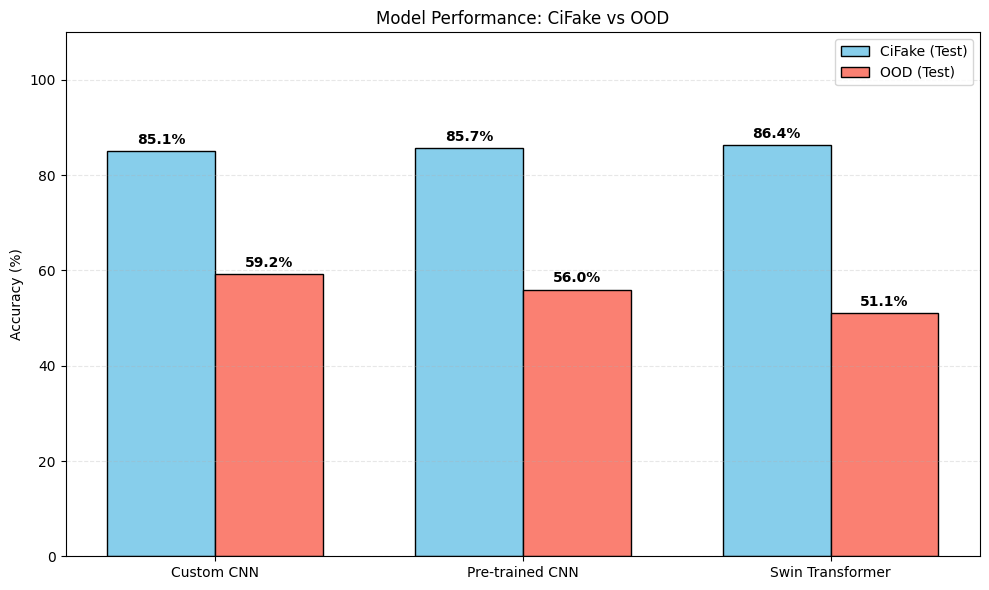

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Extract Data
models = ['Custom CNN', 'Pre-trained CNN', 'Swin Transformer']
cifake_scores = [acc_dict["Custom CNN CiFake"], acc_dict["Pre-trained CNN CiFake"], acc_dict["Swin Transformer CiFake"]]
ood_scores = [acc_dict["Custom CNN OOD"], acc_dict["Pre-trained CNN OOD"], acc_dict["Swin Transformer OOD"]]

# Convert to percentages
cifake_scores = [x * 100 for x in cifake_scores]
ood_scores = [x * 100 for x in ood_scores]

# 2. Setup Plot
x = np.arange(len(models))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, cifake_scores, width, label='CiFake (Test)', color='skyblue', edgecolor='black')
rects2 = ax.bar(x + width/2, ood_scores, width, label='OOD (Test)', color='salmon', edgecolor='black')

# 3. Styling
ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Performance: CiFake vs OOD')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 110) # slightly higher to fit text
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.3)

# 4. Helper function to put text on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

In [ ]:
# the ood set is the ds_test_ood

## 3.3 Performance on custom images 

In [ ]:
# use a pic of johannes and a pic of ai generated johannes to see if it predicts correctly 

# 4. Conclusion/Discussion

possible discussion points:
> fine tune the base layers in both pre-trained classifier and visual transformer rather than just the classifier head (time/memory constraints).


> Modify the custom cnn to see how simple it can be made while still maintaining good performance.

> The custom_cnn shows evidence of overfitting in both training plots and test set performance. Perhaps fails at catching fine-details and statistical artifacts often significant in AI generated images.

# 5. References

# 6. Division of Labour